In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm import tqdm
from torchsummary import summary


In [4]:
from google.colab import drive
drive.mount('/content/drive')

# Update if your dataset path is different
data_path = '/content/drive/MyDrive/data'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# Defining the class name
class_name = ['NORMAL','PNEUMONIA']

# Creating a function to  get the list of files
def get_list_of_files(dir_name):
    '''
    input - The input directory location
    output - Returns the list the files in the directory
    '''
    files_list = os.listdir(dir_name)
    return files_list
files_list_normal_train = get_list_of_files(data_path+'/train/'+class_name[0])
files_list_pneumonia_train = get_list_of_files(data_path+'/train/'+class_name[1])
files_list_normal_test = get_list_of_files(data_path+'/test/'+class_name[0])
files_list_pneumonia_test = get_list_of_files(data_path+'/test/'+class_name[1])

In [6]:
print("Number of train samples in Normal category {}".format(len(files_list_normal_train)))
print("Number of train samples in Pneumonia category {}".format(len(files_list_pneumonia_train)))
print("Number of test samples in Normal category {}".format(len(files_list_normal_test)))
print("Number of test samples in Pneumonia category {}".format(len(files_list_pneumonia_test)))

Number of train samples in Normal category 1266
Number of train samples in Pneumonia category 3418
Number of test samples in Normal category 317
Number of test samples in Pneumonia category 855


In [8]:
import matplotlib.image as mpimg


(1005, 1330, 3)


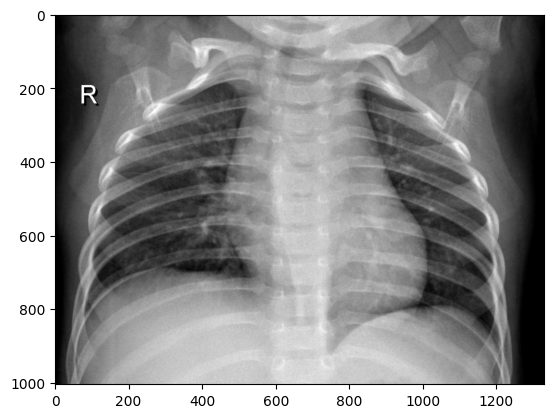

In [9]:
rand_img_no = np.random.randint(0,len(files_list_normal_train))
img = data_path + '/train/NORMAL/'+ files_list_normal_train[rand_img_no]
print(plt.imread(img).shape)
img = mpimg.imread(img)
imgplot = plt.imshow(img)
plt.show()

In [7]:
import matplotlib.image as mpimg


(992, 1088, 3)


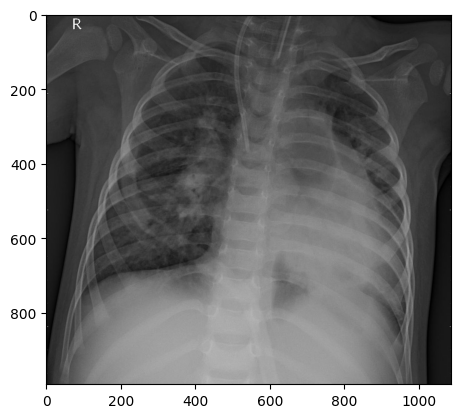

In [10]:
img = data_path + '/train/PNEUMONIA/'+ files_list_pneumonia_train[np.random.randint(0,len(files_list_pneumonia_train))]
print(plt.imread(img).shape)
img = mpimg.imread(img)
imgplot = plt.imshow(img)
plt.show()

(1171, 1429, 3)


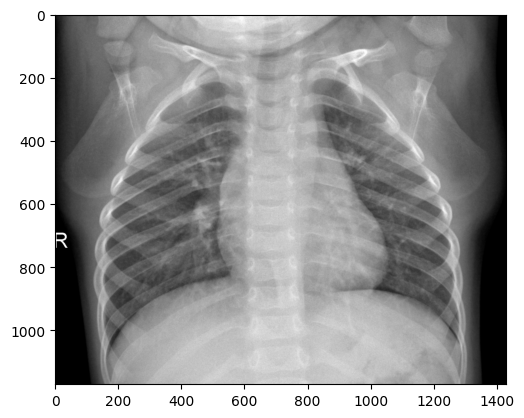

In [11]:
rand_img_no = np.random.randint(0,len(files_list_normal_test))
img = data_path + '/test/NORMAL/'+ files_list_normal_test[rand_img_no]
print(plt.imread(img).shape)
img = mpimg.imread(img)
imgplot = plt.imshow(img)
plt.show()

(653, 1287, 3)


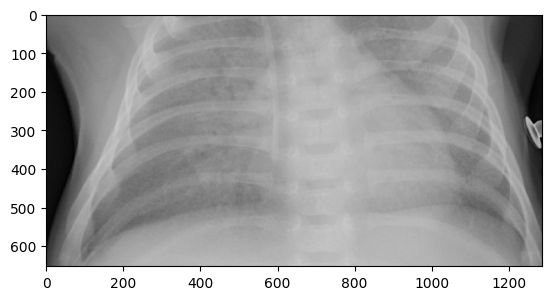

In [12]:
img = data_path + '/test/PNEUMONIA/'+ files_list_pneumonia_test[np.random.randint(0,len(files_list_pneumonia_test))]
print(plt.imread(img).shape)
img = mpimg.imread(img)
imgplot = plt.imshow(img)
plt.show()

In [13]:
train_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                          [0.229, 0.224, 0.225])
])
test_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                          [0.229, 0.224, 0.225])
])


In [14]:
train_data = datasets.ImageFolder(os.path.join(data_path, 'train'), transform= train_transform)
test_data = datasets.ImageFolder(os.path.join(data_path, 'test'), transform= test_transform)
train_loader = DataLoader(train_data,
                          batch_size= 2, shuffle= True, pin_memory= True)
test_loader = DataLoader(test_data,
                         batch_size= 2, shuffle= False, pin_memory= True)
class_names = train_data.classes
print(class_names)
print(f'Number of train images: {len(train_data)}')
print(f'Number of test images: {len(test_data)}')

['NORMAL', 'PNEUMONIA']
Number of train images: 4684
Number of test images: 1172


In [15]:
class Net(nn.Module):
    def __init__(self):
        """
        Creating custom CNN architecture for Image classification
        """
        super(Net, self).__init__()
        # Input Block
        self.convolution_block1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=(3, 3),
                      padding=0, bias=True),
            nn.ReLU(),
            nn.BatchNorm2d(8)
        )
        self.pooling11 = nn.MaxPool2d(2, 2)
        # CONVOLUTION BLOCK 1
        self.convolution_block2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=20, kernel_size=(3, 3),
                      padding=0, bias=True),
            nn.ReLU(),
            nn.BatchNorm2d(20)
        )
        self.pooling22 = nn.MaxPool2d(2, 2)
        self.convolution_block3 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(1, 1), padding=0, bias=True),
            nn.ReLU(),
            nn.BatchNorm2d(10),
        )
        self.pooling33 = nn.MaxPool2d(2, 2)
        # CONVOLUTION BLOCK 2
        self.convolution_block4 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=20, kernel_size=(3, 3), padding=0, bias=True),
            nn.ReLU(),
            nn.BatchNorm2d(20)
        )
        self.convolution_block5 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=32, kernel_size=(1, 1), padding=0, bias=True),
            nn.ReLU(),
            nn.BatchNorm2d(32),
        )
#         self.convblock6 = nn.Sequential(
#             nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(1, 1), padding='same', bias=True),
#             nn.ReLU(),
#             nn.BatchNorm2d(10),
#         )
        self.convolution_block6 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(3, 3), padding=0, bias=True),
            nn.ReLU(),
            nn.BatchNorm2d(10)
        )
#         self.convblock8 = nn.Sequential(
#             nn.Conv2d(in_channels=10, out_channels=32, kernel_size=(1, 1), padding='same', bias=True),
#             nn.ReLU(),
#             nn.BatchNorm2d(32)
#         )
        self.convolution_block7 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(1, 1), padding=0, bias=True),
            nn.ReLU(),
            nn.BatchNorm2d(10)
        )
        self.convolution_block8 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=14, kernel_size=(3, 3), padding=0, bias=True),
            nn.ReLU(),
            nn.BatchNorm2d(14)
        )
        self.convolution_block9 = nn.Sequential(
            nn.Conv2d(in_channels=14, out_channels=16, kernel_size=(3, 3), padding=0, bias=True),
            nn.ReLU(),
            nn.BatchNorm2d(16)
        )
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=4)
        )
        self.convolution_block_out = nn.Sequential(
              nn.Conv2d(in_channels=16, out_channels=2, kernel_size=(4, 4), padding=0, bias=True),
        )
    def forward(self, x):
        x = self.convolution_block1(x)
        x = self.pooling11(x)
        x = self.convolution_block2(x)
        x = self.pooling22(x)
        x = self.convolution_block3(x)
        x = self.pooling33(x)
        x = self.convolution_block4(x)
        x = self.convolution_block5(x)
#         x = self.convblock6(x)
        x = self.convolution_block6(x)
#         x = self.convblock8(x)
        x = self.convolution_block7(x)
        x = self.convolution_block8(x)
        x = self.convolution_block9(x)
        x = self.gap(x)
        x = self.convolution_block_out(x)
        x = x.view(-1, 2)   # reshape
        return F.sigmoid(x)

In [16]:
# To check weather cuda is available in the system or not
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print("Available processor {}".format(device))
model = Net().to(device)
# To check the model summary
summary(model, input_size=(3, 224, 224))

Available processor cpu
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 222, 222]             224
              ReLU-2          [-1, 8, 222, 222]               0
       BatchNorm2d-3          [-1, 8, 222, 222]              16
         MaxPool2d-4          [-1, 8, 111, 111]               0
            Conv2d-5         [-1, 20, 109, 109]           1,460
              ReLU-6         [-1, 20, 109, 109]               0
       BatchNorm2d-7         [-1, 20, 109, 109]              40
         MaxPool2d-8           [-1, 20, 54, 54]               0
            Conv2d-9           [-1, 10, 54, 54]             210
             ReLU-10           [-1, 10, 54, 54]               0
      BatchNorm2d-11           [-1, 10, 54, 54]              20
        MaxPool2d-12           [-1, 10, 27, 27]               0
           Conv2d-13           [-1, 20, 25, 25]           1,820
             Re

In [17]:
train_losses = []
test_losses = []
train_acc = []
test_acc = []
def train(model, device, train_loader, optimizer, epoch):
    """
    Description: To train the model

    input: model,device,train_loader,optimizer,epoch

    output: loss, batch id and accuracy
    """
    model.train()
    pbar = tqdm(train_loader)
    correct = 0
    processed = 0
    for batch_idx, (data, target) in enumerate(pbar):
        # get data
        data, target = data.to(device), target.to(device)
        # Initialization of gradient
        optimizer.zero_grad()
        # In PyTorch, gradient is accumulated over backprop and even though thats used in RNN generally not used in CNN
        # or specific requirements
        ## prediction on data
        y_pred = model(data)
        # Calculating loss given the prediction
        loss = F.nll_loss(y_pred, target)
        train_losses.append(loss)
        # Backprop
        loss.backward()
        optimizer.step()
        # get the index of the log-probability corresponding to the max value
        pred = y_pred.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)
        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
        train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    """
    Description: To test the model

    input: model, device, test_loader

    output: average loss and accuracy

    """
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
            test_loss, correct, len(test_loader.dataset),
            100. * correct / len(test_loader.dataset)))
    test_acc.append(100. * correct / len(test_loader.dataset))

In [19]:
from torch.optim.lr_scheduler import StepLR


In [20]:
# Defining the params for training
model =  Net().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.8)
scheduler = StepLR(optimizer, step_size=6, gamma=0.5)
EPOCHS = 1
# Training the model
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    print('current Learning Rate: ', optimizer.state_dict()["param_groups"][0]["lr"])
    test(model, device, test_loader)

EPOCH: 0


  0%|          | 0/2342 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Loss=-0.9999606013298035 Batch_id=2341 Accuracy=79.65: 100%|██████████| 2342/2342 [06:24<00:00,  6.10it/s]


current Learning Rate:  0.01

Test set: Average loss: -0.9888, Accuracy: 885/1172 (75.51%)



Text(0.5, 1.0, 'Test Accuracy')

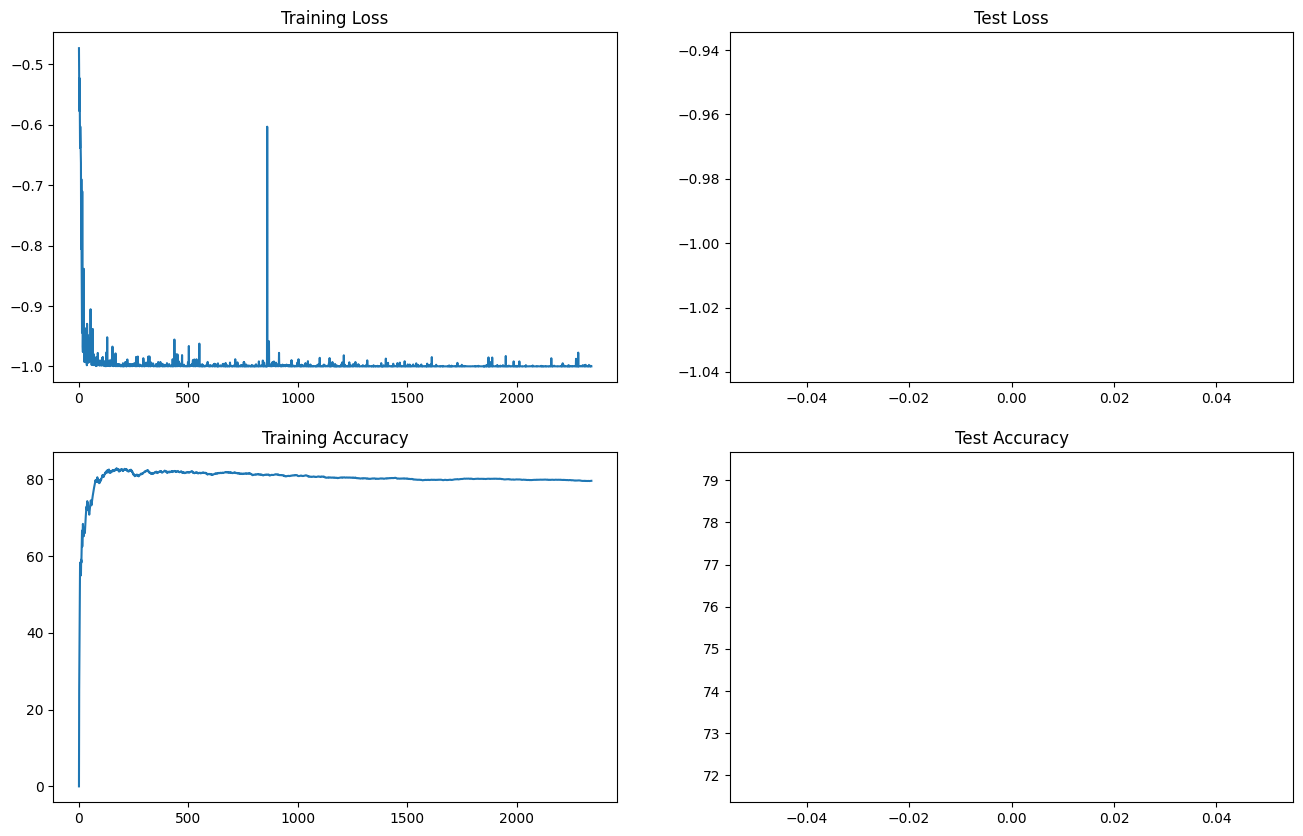

In [21]:
train_losses1 = [float(i.cpu().detach().numpy()) for i in train_losses]
train_acc1 = [i for i in train_acc]
test_losses1 = [i for i in test_losses]
test_acc1 = [i for i in test_acc]
fig, axs = plt.subplots(2,2,figsize=(16,10))
axs[0, 0].plot(train_losses1)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc1)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses1)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc1)
axs[1, 1].set_title("Test Accuracy")


In [22]:
save_dir = '/content/drive/MyDrive/saved_models'
os.makedirs(save_dir, exist_ok=True)
model_path = os.path.join(save_dir, 'xray_model.pth')
torch.save(model.state_dict(), model_path)
print("Saved model to:", model_path)

Saved model to: /content/drive/MyDrive/saved_models/xray_model.pth
